# Louis George    

## EDA of Scraped Script and Score Data

In [943]:
import numpy as np
import pandas as pd

import re
import json
import spacy

import matplotlib.pyplot as plt
%matplotlib inline

Reading in, and inspection of the script file:

In [944]:
df = pd.read_csv('../../data/scripts_upto_all.csv', index_col='Unnamed: 0')

In [945]:
df.head(2)

,titles,scripts,genres
0,10 Things I Hate About You,TEN THINGS I HA...,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1,12,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...,"['Action', 'Adventure', 'Animation', 'Comedy',..."


In [946]:
df.shape

(1210, 3)

In [947]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1210 entries, 0 to 1209
Data columns (total 3 columns):
titles     1210 non-null object
scripts    1145 non-null object
genres     1210 non-null object
dtypes: object(3)
memory usage: 37.8+ KB


In [948]:
df.isna().sum()

titles      0
scripts    65
genres      0
dtype: int64

In [949]:
df[df['scripts'].isna()]

,titles,scripts,genres
17,48 Hrs.,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
20,8 Mile,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
22,9,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
29,A.I.,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
122,Back to the Future,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
...,...,...,...
1121,Troy,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1136,Unforgiven,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1142,Valentine's Day,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1146,Vertigo,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."


After checking some of these titles, the link to the script loads a pdf, or other document type. The script that I currently have can't handle such documents. Time allowing I may revisit this.     

Now because of the way my script grabbed the genres, I also grabbed a table with links to all 18 of the various genres. This table always got read before the script genres, and so by taking everything after the first 18 I should be left with each scripts respective genre.

In [950]:
for i in range(df.shape[0]):
    df['genres'][i] = df['genres'][i].split()
    df['genres'][i] = df['genres'][i][18:]
    for j in range(len(df['genres'][i])):
        temp = re.findall('[A-Za-z]', df['genres'][i][j])
        word = ''.join(temp)
        df['genres'][i][j] = word
    df['genres'][i] = '|'.join(df['genres'][i])

Dummying the genres:

In [951]:
df = pd.concat((df, df['genres'].str.get_dummies()), axis=1).drop('genres', axis=1)

In [952]:
df.shape

(1210, 26)

I'll need to do some cleaning for that column, but it shouldn't be too bad as I will simply be removing all non alphabetic characters.    

I will now drop all 65 of the movies which I wasn't able to obtain the script for.

In [953]:
df = df.dropna().reset_index().drop('index', axis=1)

Now to dummify the genres:

Need to change format of all titles with the form: "title, The", and "Title: sub title"    

Turns out it handles the vast majority of the form: "Title: sub title" properly, and that only a handful don't go through. For that reason I am going to let them go, as there doesn't seem to be an immediatly obvious solution to capture the ones that don't go through and leave the ones that do alone (Some titles rely on both the title and sub title).   

I guess that I could do it dynamically when querying: try the whole whole title, and if not correct result try with the partial title. Will do this if time permits.

In [954]:
for i in range(df.shape[0]):
    if re.search("The$", df['titles'][i]):
        n_title = "The " + re.split(", ", df['titles'][i])[0]
        df['titles'][i] = n_title

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Now to save the titles as a csv for use to cross reference against the OMDb API and get the scores.

In [955]:
df['titles'].to_csv('../movie_titles.csv', header='titles')

### Cleaning the scores

First set, and initial investigation as I wait for the second set:

In [956]:
df_scores1 = pd.read_csv('../../data/movie_info1.csv').drop('Unnamed: 0', axis=1)

In [957]:
df_scores1.head()

,titles,info
0,10 Things I Hate About You,"{""Title"":""10 Things I Hate About You"",""Year"":""..."
1,12,"{""Title"":""12"",""Year"":""2007"",""Rated"":""PG-13"",""R..."
2,12 and Holding,"{""Title"":""12 and Holding"",""Year"":""2005"",""Rated..."
3,12 Monkeys,"{""Title"":""12 Monkeys"",""Year"":""1995"",""Rated"":""R..."
4,12 Years a Slave,"{""Title"":""12 Years a Slave"",""Year"":""2013"",""Rat..."


In [958]:
df_scores1.isna().any()

titles    False
info      False
dtype: bool

In [959]:
temp = json.loads(df_scores1['info'][9])

In [960]:
temp

{'Title': '187',
 'Year': '2016',
 'Rated': 'N/A',
 'Released': '19 Sep 2016',
 'Runtime': 'N/A',
 'Genre': 'Short, Crime',
 'Director': 'Hecht Amar',
 'Writer': 'N/A',
 'Actors': 'Hecht Amar, Mattia Bianchi',
 'Plot': 'N/A',
 'Language': 'English',
 'Country': 'USA',
 'Awards': 'N/A',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTg0NjYxZjQtNGY5Yy00OTNkLWEzODgtN2M2ZTAwMTU4YjBjL2ltYWdlL2ltYWdlXkEyXkFqcGdeQXVyMzI5OTA2MjM@._V1_SX300.jpg',
 'Ratings': [],
 'Metascore': 'N/A',
 'imdbRating': 'N/A',
 'imdbVotes': 'N/A',
 'imdbID': 'tt6217824',
 'Type': 'movie',
 'DVD': 'N/A',
 'BoxOffice': 'N/A',
 'Production': 'N/A',
 'Website': 'N/A',
 'Response': 'True'}

**Function which gets all of the target data out of the json:**

In [961]:
def get_scores(df):
    df['IMDb_score'], df['RT_score'], df['Meta_score'], df['box_office'], df['ID'] = np.nan, np.nan, np.nan, np.nan, np.nan

    for i in range(df.shape[0]):
        temp = json.loads(df['info'][i])
        try:
            for j in temp['Ratings']:
                if j['Source'] == 'Internet Movie Database':
                    df['IMDb_score'][i] = j['Value']
                elif j['Source'] == 'Rotten Tomatoes':
                    df['RT_score'][i] = j['Value']
                elif j['Source'] == 'Metacritic':
                    df['Meta_score'][i] = j['Value']
            df['box_office'][i] = temp['BoxOffice']
            df['ID'][i] = temp['imdbID']
        except:
            #print("Exception triggered")
            df['IMDb_score'][i] = np.nan
            df['RT_score'][i] = np.nan
            df['Meta_score'][i] = np.nan
            df['box_office'][i] = np.nan

In [962]:
get_scores(df_scores1)

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

In [963]:
df_scores1.head()

,titles,info,IMDb_score,RT_score,Meta_score,box_office,ID
0,10 Things I Hate About You,"{""Title"":""10 Things I Hate About You"",""Year"":""...",7.3/10,68%,70/100,N/A,tt0147800
1,12,"{""Title"":""12"",""Year"":""2007"",""Rated"":""PG-13"",""R...",7.7/10,76%,72/100,N/A,tt0488478
2,12 and Holding,"{""Title"":""12 and Holding"",""Year"":""2005"",""Rated...",7.5/10,73%,65/100,N/A,tt0417385
3,12 Monkeys,"{""Title"":""12 Monkeys"",""Year"":""1995"",""Rated"":""R...",8.0/10,89%,74/100,N/A,tt0114746
4,12 Years a Slave,"{""Title"":""12 Years a Slave"",""Year"":""2013"",""Rat...",8.1/10,95%,96/100,"$50,628,650",tt2024544


In [964]:
df_scores1.isna().sum()

titles         0
info           0
IMDb_score    27
RT_score      58
Meta_score    72
box_office    24
ID            24
dtype: int64

In [965]:
df_scores1[df_scores1['RT_score'].isna()].head()

,titles,info,IMDb_score,RT_score,Meta_score,box_office,ID
9,187,"{""Title"":""187"",""Year"":""2016"",""Rated"":""N/A"",""Re...",NaN,NaN,NaN,N/A,tt6217824
17,50-50,"{""Title"":""50-50"",""Year"":""2011"",""Rated"":""N/A"",""...",6.1/10,NaN,NaN,N/A,tt1833204
30,Adaptation,"{""Title"":""Adaptation"",""Year"":""2019–"",""Rated"":""...",NaN,NaN,NaN,NaN,NaN
33,The Adventures of Buckaroo Banzai Across the E...,"{""Response"":""False"",""Error"":""Movie not found!""}",NaN,NaN,NaN,NaN,NaN
35,After School Special,"{""Title"":""After School Special"",""Year"":""2017"",...",2.3/10,NaN,NaN,N/A,tt3291632


**Function which cleans up the score features:**

In [966]:
def score_cleaner(df, col):
    for i in range(df.shape[0]):
        try:
            if col[i] == 'N/A':
                col[i] = np.nan
            elif '/' in col[i]:
                y = col[i].split('/')
                col[i] = round(float(y[0]) / float(y[1]), 2)
            elif '%' in col[i]:
                col[i] = round(int(col[i].split('%')[0]) / 100, 2)
            elif "$" in col[i]:
                col[i] = int(''.join(re.findall('[0-9]', col[i])))
        except:
            continue

In [967]:
score_cleaner(df_scores1, df_scores1['IMDb_score'])
score_cleaner(df_scores1, df_scores1['RT_score'])
score_cleaner(df_scores1, df_scores1['Meta_score'])
score_cleaner(df_scores1, df_scores1['box_office'])

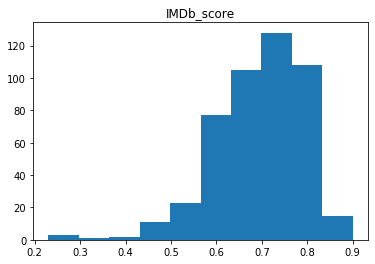

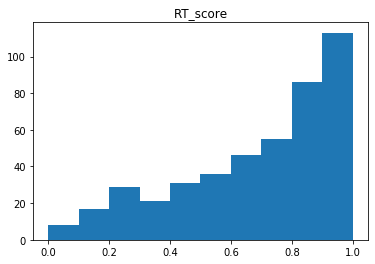

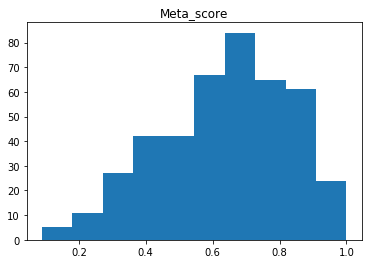

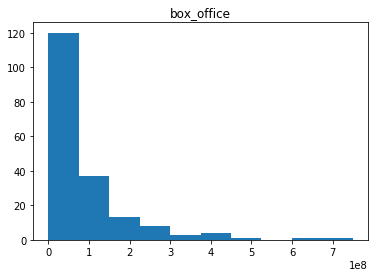

In [968]:
for i in df_scores1.columns[2:6]:
    plt.figure()
    plt.hist(df_scores1[i])
    plt.title(i)
    plt.show();

In [969]:
df_scores1.isna().sum()

titles          0
info            0
IMDb_score     27
RT_score       58
Meta_score     72
box_office    312
ID             24
dtype: int64

____________________________________________________
**Second set:**

In [970]:
df_scores2 = pd.read_csv('../../data/movie_info2.csv').drop('Unnamed: 0', axis=1)

In [971]:
df_scores2.shape

(645, 2)

In [972]:
get_scores(df_scores2)
score_cleaner(df_scores2, df_scores2['IMDb_score'])
score_cleaner(df_scores2, df_scores2['RT_score'])
score_cleaner(df_scores2, df_scores2['Meta_score'])
score_cleaner(df_scores2, df_scores2['box_office'])

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

In [973]:
df_scores2.head()

,titles,info,IMDb_score,RT_score,Meta_score,box_office,ID
0,Hellraiser,"{""Title"":""Hellraiser"",""Year"":""1987"",""Rated"":""R...",0.7,0.7,0.57,NaN,tt0093177
1,Hellraiser 3: Hell on Earth,"{""Response"":""False"",""Error"":""Movie not found!""}",NaN,NaN,NaN,NaN,NaN
2,Hellraiser: Deader,"{""Title"":""Hellraiser: Deader"",""Year"":""2005"",""R...",0.46,0.17,NaN,NaN,tt0337636
3,Hellraiser: Hellseeker,"{""Title"":""Hellraiser: Hellseeker"",""Year"":""2002...",0.5,0,0.46,NaN,tt0274546
4,The Help,"{""Title"":""The Help"",""Year"":""2011"",""Rated"":""PG-...",0.81,0.76,0.62,169705587,tt1454029


In [974]:
df_scores2.isna().sum()

titles          0
info            0
IMDb_score     38
RT_score       79
Meta_score    114
box_office    354
ID             33
dtype: int64

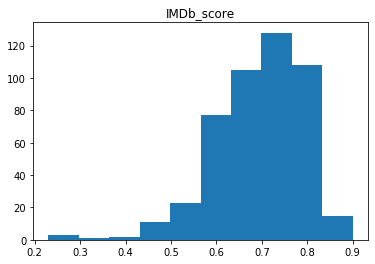

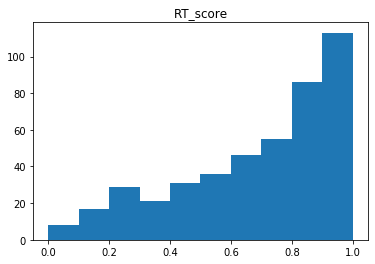

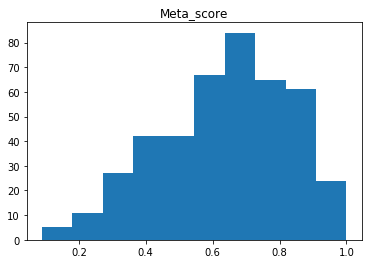

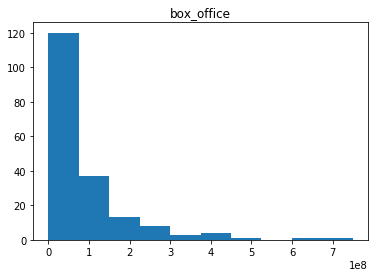

In [975]:
for i in df_scores2.columns[2:6]:
    plt.figure()
    plt.hist(df_scores1[i])
    plt.title(i)
    plt.show();

__________________________________

Judging from the results of the omdbapi scraping, the box office revenue, and Metacritic score are unusable, and I will have to drop those columns entirely.    

I will have to drop about 10% of the remainder of my rows in order to use Rotten Tomatoes, and IMDb scores.    

Overall this isn't ideal, as my dataset is already relatively small. If time permits, I may revisit the scraper and try to optimize more.

__________________________________

From these figures it would appear as though we need to drop box office, however we are given the imdb movie ID, which will allow me to scrape their website relatively easily (ie sans Selenium). I'll do that and see if I can get enough data to work with.

For that I need to export the IDs for the scraper to do it's thing. To do this, as well as proceed with the project anyway I will need to join the two dataframes:

In [976]:
df_scores1 = df_scores1.drop(['info', 'Meta_score', 'box_office'], axis=1)
df_scores2 = df_scores2.drop(['info', 'Meta_score', 'box_office'], axis=1)
df_scores = pd.concat([df_scores1, df_scores2], axis=0).reset_index().drop('index', axis=1)

In [977]:
df_scores.head()

,titles,IMDb_score,RT_score,ID
0,10 Things I Hate About You,0.73,0.68,tt0147800
1,12,0.77,0.76,tt0488478
2,12 and Holding,0.75,0.73,tt0417385
3,12 Monkeys,0.8,0.89,tt0114746
4,12 Years a Slave,0.81,0.95,tt2024544


In [978]:
df_scores.shape

(1145, 4)

Exporting the ids for scraper:

In [979]:
df_scores['ID'].to_csv('../web_scraper/imbd_ids.csv', header='ID')

Importing the scraped data:

In [993]:
df_imdb = pd.read_csv('../../data/imdb_scrape.csv', index_col='Unnamed: 0').reset_index().drop('index', axis=1)

In [999]:
if 'Cumulative' in df_imdb['info'][0]:
    print('ye')
df_imdb['info'][0]

ye


'Edit\nDetails\nCountry: USA\nLanguage: English | French\nRelease Date: 31 March 1999 (USA) See more »\nAlso Known As: 10 Things I Hate About You See more »\nFilming Locations: 2715 North Junett Street, Tacoma, Washington, USA See more »\nEdit\nBox Office\nBudget:$30,000,000 (estimated)\nOpening Weekend USA: $8,330,681, 4 April 1999\nGross USA: $38,178,166\nCumulative Worldwide Gross: $53,478,166\nSee more on IMDbPro »\nCompany Credits\nProduction Co: Touchstone Pictures, Mad Chance, Jaret Entertainment See more »\nShow more on IMDbPro »\nTechnical Specs\nRuntime: 97 min\nSound Mix: Dolby Digital | SDDS | DTS\nColor: Color\nAspect Ratio: 1.85 : 1\nSee full technical specs »'

In [1001]:
df_scores['Gross_world'], df_scores['Gross_US'], df_scores['Opening_US'], df_scores['Budget'] = np.nan, np.nan, np.nan, np.nan

for i in range(df_imdb.shape[0]):
    if type(df_imdb['info'][i]) == float:
        pass
    else:
        for j in df_imdb['info'][i].split('\n'):
            if 'Budget' in j:
                df_scores['Budget'][i] = j
            if 'Opening' in j:
                df_scores['Opening_US'][i] = j
            if 'Gross' in j:
                df_scores['Gross_US'][i] = j
            if 'Cumulative' in j:
                df_scores['Gross_world'][i] = j

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

In [1002]:
df_imdb.shape

(1145, 2)

In [1005]:
df_scores.shape

(1145, 8)

In [1003]:
df_imdb.isna().sum()

ID      57
info    58
dtype: int64

In [1004]:
df_scores.isna().sum()

titles           0
IMDb_score      65
RT_score       137
ID              57
Gross_world    153
Gross_US       148
Opening_US     211
Budget         162
dtype: int64

Combining the final dataframes in order to drop the nans:

In [782]:
df_combined = pd.concat([df_scores, df], axis=1)

In [783]:
df_combined.columns

Index(['titles', 'IMDb_score', 'RT_score', 'titles', 'scripts', 'Action',
       'ActionThriller', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Drama', 'Family', 'Fantasy', 'FilmNoir', 'History', 'Horror',
       'HorrorMystery', 'Music', 'Musical', 'Mystery', 'Romance', 'SciFi',
       'Short', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [784]:
df_fc = df_combined.dropna().reset_index().drop('index', axis=1)

In [785]:
df_fc.shape

(1008, 29)

### Tokenizing the Scripts

Vectorizer takes in a tokenizer. We then use this blown up df in models.

In [620]:
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

In [621]:
tokens = nlp(df['scripts'][0])

In [622]:
count = 0
for i in tokens:
    print(i, i.is_stop)
    count += 1
    if count > 30:
        break

                                False
TEN True
THINGS False
I True
HATE False
ABOUT True
YOU True

          
                 False
written False
by True
Karen False
McCullah False
Lutz False
& False
Kirsten False
Smith False

          
               False
based False
on True
' False
Taming False
of True
the True
Shrew False
" False
by True
William False
Shakespeare False

          
           False
Revision False
November False


In [623]:
def my_tokenizer(string):
    doc = nlp(string)
    tokens = []
    for token in doc:
        if token.is_stop == False:
            tokens.append(token.lemma_)
        elif token.is_punct == False:
            tokens.append(token.lemma_)
        elif token.is_space == False:
            tokens.append(token.lemma_)


    return tokens

In [624]:
temp = my_tokenizer(df['scripts'][0])
count = 0

for i in temp:
    count += 1
    print(i)
    if count > 30:
        break

                               
TEN
THINGS
I
HATE
ABOUT
YOU

          
                
write
by
Karen
McCullah
Lutz
&
Kirsten
Smith

          
              
base
on
'
Taming
of
the
Shrew
"
by
William
Shakespeare

          
          
Revision
November


In [625]:
from sklearn.feature_extraction.text import CountVectorizer

In [626]:
temp_df = df['scripts'][:2]

In [627]:
bagowords = CountVectorizer(tokenizer=my_tokenizer)

In [628]:
test = bagowords.fit_transform(temp_df)

In [629]:
test

<2x3733 sparse matrix of type '<class 'numpy.int64'>'
	with 4680 stored elements in Compressed Sparse Row format>

In [630]:
my_df = pd.DataFrame(columns=bagowords.get_feature_names(), data=test.toarray())
my_df.sum().head(20)

\n                                                                                                                                                                                                                    651
\n\n                                                                                                                                                                                                                  469
\n\n\n                                                                                                                                                                                                                 19
\n\n\n\n                                                                                                                                                                                                                2
\n\n\n                                                                                                                          